In [5]:
DATA_DIR = "/Users/user/Desktop/ml-100k"
import os
print(os.listdir(DATA_DIR))


['u.item', 'u3.test', 'u1.base', 'u.info', 'u2.test', 'u5.test', 'u.genre', 'ub.test', 'ua.base', 'u.data', 'README', 'u4.test', 'u5.base', 'ub.base', 'ua.test', 'u4.base', 'u.user', 'allbut.pl', 'u3.base', 'u1.test', 'mku.sh', 'u2.base', 'u.occupation']


In [8]:
%%writefile movielens100k_utils.py
from __future__ import annotations
from dataclasses import dataclass
import os, re
import numpy as np
import pandas as pd

@dataclass
class ML100K:
    ratings: pd.DataFrame
    movies: pd.DataFrame | None
    users: pd.DataFrame | None
    user_map: dict[int, int]
    item_map: dict[int, int]

    @property
    def n_users(self) -> int: return len(self.user_map)
    @property
    def n_items(self) -> int: return len(self.item_map)

def _has(path: str, *names: str) -> bool:
    return all(os.path.exists(os.path.join(path, n)) for n in names)

def detect_format(path: str) -> str:
    if _has(path, "u.data"): return "grouplens"
    if _has(path, "ratings.csv"): return "csv"
    raise FileNotFoundError("Expected GroupLens u.* files or Kaggle ratings.csv in the folder")

def _read_grouplens(path: str):
    # u.data: user id | item id | rating | timestamp (tab)
    ratings = pd.read_csv(os.path.join(path, "u.data"), sep="\t",
                          names=["userId","movieId","rating","timestamp"], engine="python")
    # u.item (pipe) + u.genre (optional)
    movies = None
    if os.path.exists(os.path.join(path, "u.item")):
        cols = ["movieId","title","release_date","video_release_date","imdb_url"] + [f"g{i}" for i in range(19)]
        raw = pd.read_csv(os.path.join(path, "u.item"), sep="|", names=cols, engine="python", encoding_errors="ignore")
        genre_names = None
        gpath = os.path.join(path, "u.genre")
        if os.path.exists(gpath):
            gdf = pd.read_csv(gpath, sep="|", names=["genre","id"], engine="python").sort_values("id")
            genre_names = gdf["genre"].tolist()
        if genre_names and len(genre_names)==19:
            gcols = [f"g{i}" for i in range(19)]
            genres = raw[gcols].apply(lambda row: [g for g,flag in zip(genre_names,row.values) if int(flag)==1], axis=1)
        else:
            genres = [[]]*len(raw)
        movies = pd.DataFrame({"movieId": raw["movieId"].astype(int),
                               "title": raw["title"],
                               "genres": genres})
    # u.user (pipe): user id | age | gender | occupation | zip
    users = None
    if os.path.exists(os.path.join(path, "u.user")):
        users = pd.read_csv(os.path.join(path,"u.user"), sep="|",
                            names=["userId","age","gender","occupation","zip"], engine="python")
    return ratings, movies, users

def _read_csv_variant(path: str):
    ratings = pd.read_csv(os.path.join(path, "ratings.csv")).rename(columns={"user":"userId","item":"movieId"})
    if "timestamp" not in ratings.columns: ratings["timestamp"]=0
    movies = pd.read_csv(os.path.join(path, "movies.csv")) if os.path.exists(os.path.join(path,"movies.csv")) else None
    if movies is not None and "genres" in movies.columns:
        movies["genres"] = movies["genres"].fillna("").apply(lambda s: s.split("|") if isinstance(s,str) and s else [])
    users = None
    return ratings, movies, users

def load_movielens_100k(path: str) -> ML100K:
    fmt = detect_format(path)
    ratings, movies, users = (_read_grouplens(path) if fmt=="grouplens" else _read_csv_variant(path))
    ratings = ratings.astype({"userId":int,"movieId":int,"rating":float,"timestamp":int})
    if movies is not None and "movieId" in movies.columns:
        movies["movieId"] = movies["movieId"].astype(int)
    user_ids = np.sort(ratings["userId"].unique())
    item_ids = np.sort(ratings["movieId"].unique())
    user_map = {uid:i for i,uid in enumerate(user_ids)}
    item_map = {iid:i for i,iid in enumerate(item_ids)}
    return ML100K(ratings=ratings, movies=movies, users=users, user_map=user_map, item_map=item_map)


Writing movielens100k_utils.py


In [15]:
from movielens100k import load_movielens_100k

DATA_DIR = "/Users/user/movielens data and code/ml-100k"  # your folder with u.data etc.
data = load_movielens_100k(DATA_DIR)
print(data.ratings.head())
print(data.n_users, data.n_items)


   userId  movieId  rating  timestamp
0     196      242     3.0  881250949
1     186      302     3.0  891717742
2      22      377     1.0  878887116
3     244       51     2.0  880606923
4     166      346     1.0  886397596
943 1682


# 1. Ratings Distribution


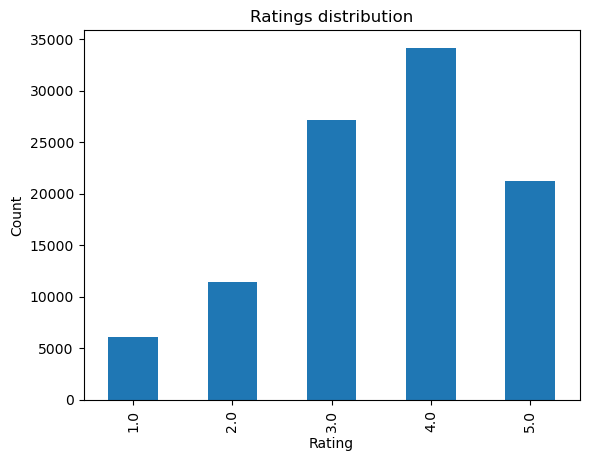

In [18]:
import matplotlib.pyplot as plt

ratings = data.ratings

import matplotlib.pyplot as plt

ratings["rating"].value_counts().sort_index().plot(kind="bar")
plt.title("Ratings distribution")
plt.xlabel("Rating")
plt.ylabel("Count")
plt.show()

# 2. Most Popular Movies

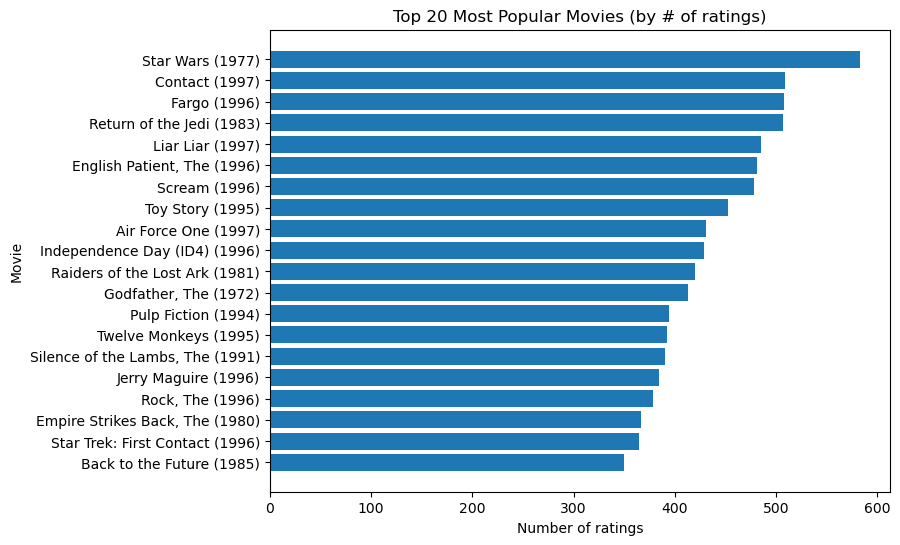

,movieId,count,title
0,50,583,Star Wars (1977)
1,258,509,Contact (1997)
2,100,508,Fargo (1996)
3,181,507,Return of the Jedi (1983)
4,294,485,Liar Liar (1997)
5,286,481,"English Patient, The (1996)"
6,288,478,Scream (1996)
7,1,452,Toy Story (1995)
8,300,431,Air Force One (1997)
9,121,429,Independence Day (ID4) (1996)


In [26]:
import matplotlib.pyplot as plt
import pandas as pd

# Count ratings per movie
movie_counts = ratings["movieId"].value_counts().rename_axis("movieId").reset_index(name="count")

# Attach movie titles if available
if data.movies is not None:
    movie_counts = movie_counts.merge(data.movies[["movieId","title"]], on="movieId", how="left")

# Top 20 most popular movies
top20 = movie_counts.head(20)

plt.figure(figsize=(8,6))
plt.barh(top20["title"].astype(str), top20["count"])
plt.gca().invert_yaxis()
plt.title("Top 20 Most Popular Movies (by # of ratings)")
plt.xlabel("Number of ratings")
plt.ylabel("Movie")
plt.show()

#show table
top20


# 3. Most Popular Genres

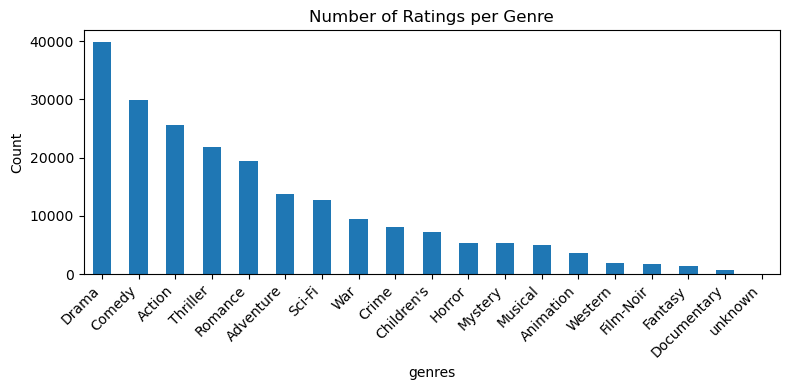

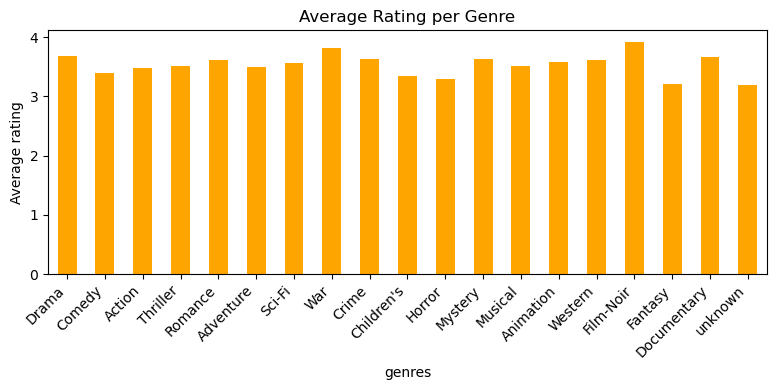

In [27]:
import matplotlib.pyplot as plt

ratings = data.ratings

if data.movies is not None and "genres" in data.movies.columns:
    # Expand genres list into separate rows
    movies_genres = data.movies.explode("genres")

    # Merge ratings with genres
    merged = ratings.merge(movies_genres[["movieId","genres"]], on="movieId", how="left")

    # Group by genre
    genre_stats = merged.groupby("genres")["rating"].agg(["count","mean"]).sort_values("count", ascending=False)

    # Plot counts (popularity of genres)
    plt.figure(figsize=(8,4))
    genre_stats["count"].plot(kind="bar")
    plt.title("Number of Ratings per Genre")
    plt.ylabel("Count")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

    # Plot average ratings
    plt.figure(figsize=(8,4))
    genre_stats["mean"].plot(kind="bar", color="orange")
    plt.title("Average Rating per Genre")
    plt.ylabel("Average rating")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

    genre_stats
else:
    print("No genre information found in data.movies.")
